In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(data.table))


In [274]:
library(gridExtra)

In [2]:
source('PRS_PheWAS_functions.R')

In [3]:
# input
gwas_covar_f <- '@@@@@@@@@@@@@@@@@@@'
icd_phe_f <- '@@@@@@@@@@@@@@@@@@@'
data_dir <- '@@@@@@@@@@@@@@@@@@@'
prs_f <- file.path(data_dir, 'snpnet.PRS.tsv.zst')


In [35]:
phe_info_f <- '../snpnet/pheno.info.tsv'

In [291]:
# output
phewas_icd_f <- file.path(data_dir, 'phewas.white_british.full.icd.tsv')
PRS_PheWAS_summary_icd_f <- 'phewas.white_british.icd.summary.tsv'
PRS_PheWAS_summary_icd_plot <- 'phewas.white_british.icd.summary.png'
PRS_icd_OR_f <- file.path(data_dir, 'PRS.icd.OR.full.tsv')
PRS_icd_OR_summary_f <- 'PRS.icd.OR.summary.tsv'
PRS_icd_OR_summary_plot_prefix <- 'figs/PRS.icd.OR'


In [4]:
covariates <- c('age', 'sex', 'N_CNV', 'LEN_CNV', 'Array', paste0('PC', 1:10))

In [8]:
traits_for_write_up <- c(
    'INI30190',
    'INI30150',
    'INI30210',
    'INI30120',
    'INI30180',
    'INI30140',
    'INI30200',
    'INI30000'
)


In [36]:
# read phenotype meta data file
phe_info_df <- fread(phe_info_f) %>%
rename('GBE_ID' = '#GBE_ID')


In [5]:
gwas_covar_df <- fread(
    gwas_covar_f,
    select=c('FID', 'IID', 'population', 'split', 'age', 'sex', 'N_CNV', 'LEN_CNV', 'Array', paste0('PC', 1:10)),
    colClasses=c('FID'='character', 'IID'='character')
)


In [6]:
icd_phe_df <- fread(icd_phe_f, colClasses=c('#FID'='character', 'IID'='character')) %>%
rename('FID' = '#FID') %>%
mutate_if(is.numeric, function(x){x - 1})


In [7]:
prs_df <- fread(cmd=paste('zstdcat', prs_f), colClasses=c('#FID'='character', 'IID'='character')) %>%
rename('FID' = '#FID')


In [9]:
df <- gwas_covar_df %>%
left_join(icd_phe_df, by=c('FID', 'IID')) %>%
left_join(prs_df, by=c('FID', 'IID'))


In [328]:
df %>% 
filter(population %in% c('white_british', 's_asian', 'non_british_white')) %>%
count(ICD_disease)


ICD_disease,n
<dbl>,<int>
0,349000
1,20928


In [327]:
df %>% 
filter(population %in% c('white_british', 's_asian', 'non_british_white')) %>%
count(ICD_death)


ICD_death,n
<dbl>,<int>
0,368082
1,1846


In [11]:
# PRS_cols <- colnames(prs_df)[3:5]
# PRS_cols <- colnames(prs_df)[3:ncol(prs_df)] # all traits
# PRS_cols <- colnames(prs_df)[3:31] # all blood
PRS_cols <- traits_for_write_up %>% lapply(function(x){paste0(x, '_PRS')})


In [12]:
# phenotypes <- c('INI23000', 'INI23001')
phenotypes <- colnames(icd_phe_df)[3:4]


In [93]:
pop_dfs <- list()
phewas_res_dfs <- list()
pops_all <- c('white_british', 'non_british_white', 'african', 's_asian', 'e_asian', 'Chinese', 'Indian',  'Pakistani', 'Bangladeshi')
for(pop in pops_all){
    print(pop)
    
    pop_dfs[[pop]] <- df %>%
    filter(population == pop)

    tryCatch({
        
        phewas_res_dfs[[pop]] <- pop_dfs[[pop]] %>%
        phewas_loop(phenotypes, PRS_cols, covariates, 'binomial') %>%
        mutate(
            OR=exp(BETA),
            OR_str = sprintf('%.3f (%.3f,%.3f)', OR, exp(l_err), exp(u_err))
        )    
        
        phewas_res_dfs[[pop]]$BH <- p.adjust(phewas_res_dfs[[pop]]$P, method = 'BH')
        
    }, error=function(e){print(e)})            
}


[1] "white_british"
[1] "non_british_white"
[1] "african"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] "s_asian"
[1] "e_asian"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Wa

[1] "Chinese"
<simpleError: object 'BETA' not found>
[1] "Indian"
<simpleError: object 'BETA' not found>
[1] "Pakistani"
<simpleError: object 'BETA' not found>
[1] "Bangladeshi"
<simpleError: object 'BETA' not found>


In [96]:
phewas_res_df <- phewas_res_dfs %>%
names() %>%
lapply(function(pop){phewas_res_dfs[[pop]] %>% mutate(population = pop)}) %>%
bind_rows()
    

In [83]:
# phewas_res_df <- pop_df %>%
# phewas_loop(phenotypes, PRS_cols, covariates, 'binomial') %>%
# mutate(
#     OR=exp(BETA),
#     OR_str = sprintf('%.3f (%.3f,%.3f)', OR, exp(l_err), exp(u_err))
# )


In [84]:
# phewas_res_df$BH <- p.adjust(phewas_res_df$P, method = 'BH')


In [86]:
# phewas_res_df %>%
# rename('#phenotype' = 'phenotype') %>%
# fwrite(phewas_icd_f, sep='\t', na = "NA", quote=F)


In [97]:
phewas_res_df %>%
rename('#phenotype' = 'phenotype') %>%
fwrite(phewas_icd_f, sep='\t', na = "NA", quote=F)


In [98]:
phewas_res_df %>% 
select(phenotype, PRS_col) %>%
unique() %>% nrow()

[1] 16

In [99]:
phewas_plot_df <- phewas_res_df %>% 
left_join(
    phe_info_df %>%
    mutate(
        PRS_col = paste0(GBE_ID, '_PRS')
    ) %>%
    select(PRS_col, pheno_plot) %>%
    rename('PRS_pheno'='pheno_plot'),
    by='PRS_col'
)


In [113]:
phewas_summary_df <- phewas_plot_df %>% 
select(population, phenotype, PRS_col, PRS_pheno, OR_str, P_str, BH) %>%
rename('PRS'='PRS_col', 'OR'='OR_str', 'P'='P_str')


In [171]:
phewas_summary_df %>%
arrange(phenotype, PRS) %>%
filter(population %in% c('white_british', 'non_british_white', 's_asian')) %>%
select(-BH) %>%
rename('#population' = 'population') %>%
fwrite(PRS_PheWAS_summary_icd_f, sep='\t', na = "NA", quote=F)


In [115]:
p1 <- phewas_plot_df %>%
filter(phenotype == 'ICD_disease', population=='white_british') %>%
ggplot(aes(x=PRS_pheno, y=-log10(P))) +
geom_point() +
geom_hline(yintercept = 3, color='blue')+
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=.5))  


In [116]:
p2 <- phewas_plot_df %>%
filter(phenotype == 'ICD_death', population=='white_british') %>%
ggplot(aes(x=PRS_pheno, y=-log10(P))) +
geom_point() +
geom_hline(yintercept = 3, color='blue')+
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=.5))
# element_blank()


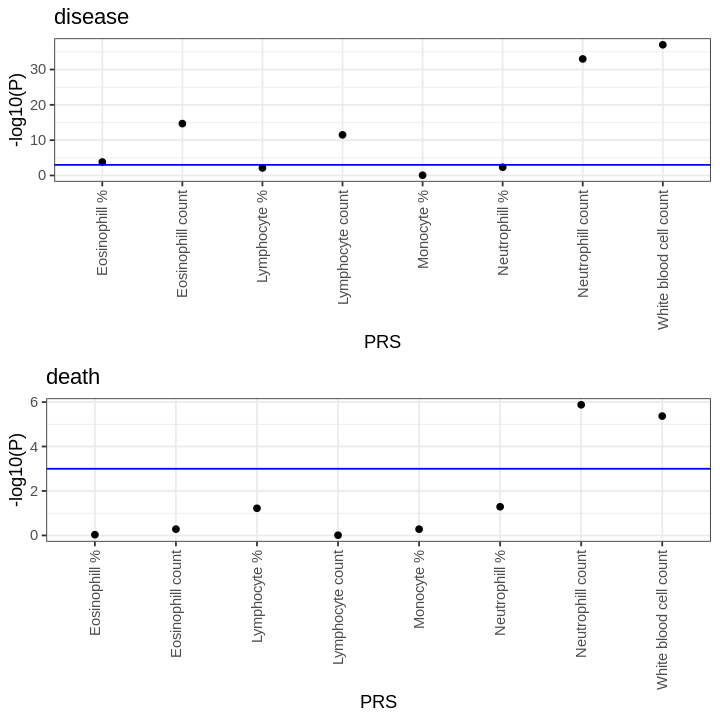

In [117]:
options(repr.plot.width=6, repr.plot.height=6)
gridExtra::grid.arrange(
    p1 + labs(title='disease', x='PRS'), 
    p2 + labs(title='death', x='PRS'), 
    ncol=1
)

In [140]:
prs_percentile_df <- gwas_covar_df %>%
select(FID, IID, population) %>%
filter(population %in% c('white_british', 'non_british_white', 's_asian')) %>%
left_join(prs_df, by=c('FID', 'IID')) %>%
group_by(population) %>%
mutate_if(is.numeric, function(x){rank(-x)/n()})%>%
ungroup()


`mutate_if()` ignored the following grouping variables:
Column `population`


In [144]:
OR_analysis_df <- icd_phe_df %>%
inner_join(prs_percentile_df, by=c('FID', 'IID'))


In [146]:
OR_analysis_df %>% count(population)

population,n
<chr>,<int>
non_british_white,24905
s_asian,7885
white_british,337138


In [216]:
OR_results_df <- c('white_british', 'non_british_white', 's_asian') %>%
lapply(function(pop){    
    lapply(phenotypes, function(phe){
        lapply(PRS_cols, function(PRS_col){
            tryCatch({
                OR_analysis_df %>%
                filter(population == pop) %>%
                compute_summary_df(PRS_col, phe, bins=(0:10)/10, metric='OR') %>%
                mutate(population = pop, phenotype = phe, PRS = PRS_col)
            }, error=function(e){})
        }) %>% bind_rows()
    }) %>% bind_rows()
}) %>% bind_rows()


In [217]:
OR_plot_df <- OR_results_df %>% 
left_join(
    phe_info_df %>%
    mutate(
        PRS = paste0(GBE_ID, '_PRS')
    ) %>%
    select(PRS, pheno_plot) %>%
    rename('PRS_pheno'='pheno_plot'),
    by='PRS'
) %>%
select(population, phenotype, PRS, PRS_pheno, bin_str, OR_str, OR, SE_LOR, n_TP, n_FN, n_FP, n_TN, l_OR, u_OR, l_bin, u_bin)


In [218]:
OR_plot_df %>% 
arrange(phenotype, PRS) %>%
rename('#population' = 'population') %>%
fwrite(PRS_icd_OR_f, sep='\t', na = "NA", quote=F)


In [219]:
OR_plot_df %>% 
arrange(phenotype, PRS) %>%
select(population, phenotype, PRS, PRS_pheno, bin_str, OR_str) %>%
rename('#population' = 'population') %>%
fwrite(PRS_icd_OR_summary_f, sep='\t', na = "NA", quote=F)


In [220]:
phe_info_plot_names <- setNames(phe_info_df$pheno_plot, phe_info_df$GBE_ID)

In [221]:
plot_name_patch <- function(name){
    name %>%
    str_replace_all('%', 'percentage')
}


In [228]:
plot_panel <- function(df, pop, PRS_col, phe){    
    df %>%
    filter(
        population == pop, 
        PRS == PRS_col,
        phenotype == phe
    ) %>%
    mutate(x_ticks_labels = paste0('[', bin_str, ']')) %>%
    ggplot(aes(x=reorder(x_ticks_labels, -u_bin), y=OR)) +
    geom_point() + 
    geom_errorbar(aes(ymin = l_OR, ymax = u_OR)) +
    geom_hline(yintercept = 1, color='gray')+
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=.5))
}

In [233]:
phenotype_plot_names <- setNames(
    c('Disease', 'Death'),    
    c('ICD_disease', 'ICD_death')
)

population_plot_names <- setNames(
    c('White British', 'Non-British white', 'South Asian'),    
    c('white_british', 'non_british_white', 's_asian')
)


In [317]:
OR_plots <- list()
OR_plot_pops <- c('white_british', 'non_british_white', 's_asian')
for(pop in OR_plot_pops){
    OR_plots[[ pop ]] <- list()
    for(phe in phenotypes){
        OR_plots[[ pop ]][[ phe ]] <- list()
        for(PRS_col in PRS_cols){
            OR_plots[[ pop ]][[ phe ]][[PRS_col]] <- OR_plot_df %>%
            plot_panel(pop, PRS_col, phe)+ 
            labs(
                title = sprintf(
                    '%s (%s)',                     
                    plot_name_patch(phe_info_plot_names[[ str_replace(PRS_col, '_PRS', '') ]]),
                    population_plot_names[[pop]]
                ),
                x = sprintf('The percentile of snpnet PRS (%s)', str_replace(PRS_col, '_PRS', '')),
                y = sprintf('%s risk odds ratio (standard error)', phenotype_plot_names[[phe]])
            ) 
        }
        
        fig_name <- paste(PRS_icd_OR_summary_plot_prefix, phenotype_plot_names[[phe]], pop, 'png', sep='.')
        # we sort the plots by P-value
        plist <- phewas_summary_df %>%
        filter(population == pop, phenotype == phe) %>%
        arrange(P) %>% select(PRS) %>% pull() %>%
        lapply(function(PRS_col){OR_plots[[ pop ]][[ phe ]][[ PRS_col ]] })

        nCol <- 3
        options(repr.plot.width=14, repr.plot.height=14)
        g <- do.call("arrangeGrob", c(plist, ncol=nCol))
        ggsave(fig_name, g, width=14, height=14)        
    }
}


In [313]:
pop <- 'white_british' 
phe <- 'ICD_disease'


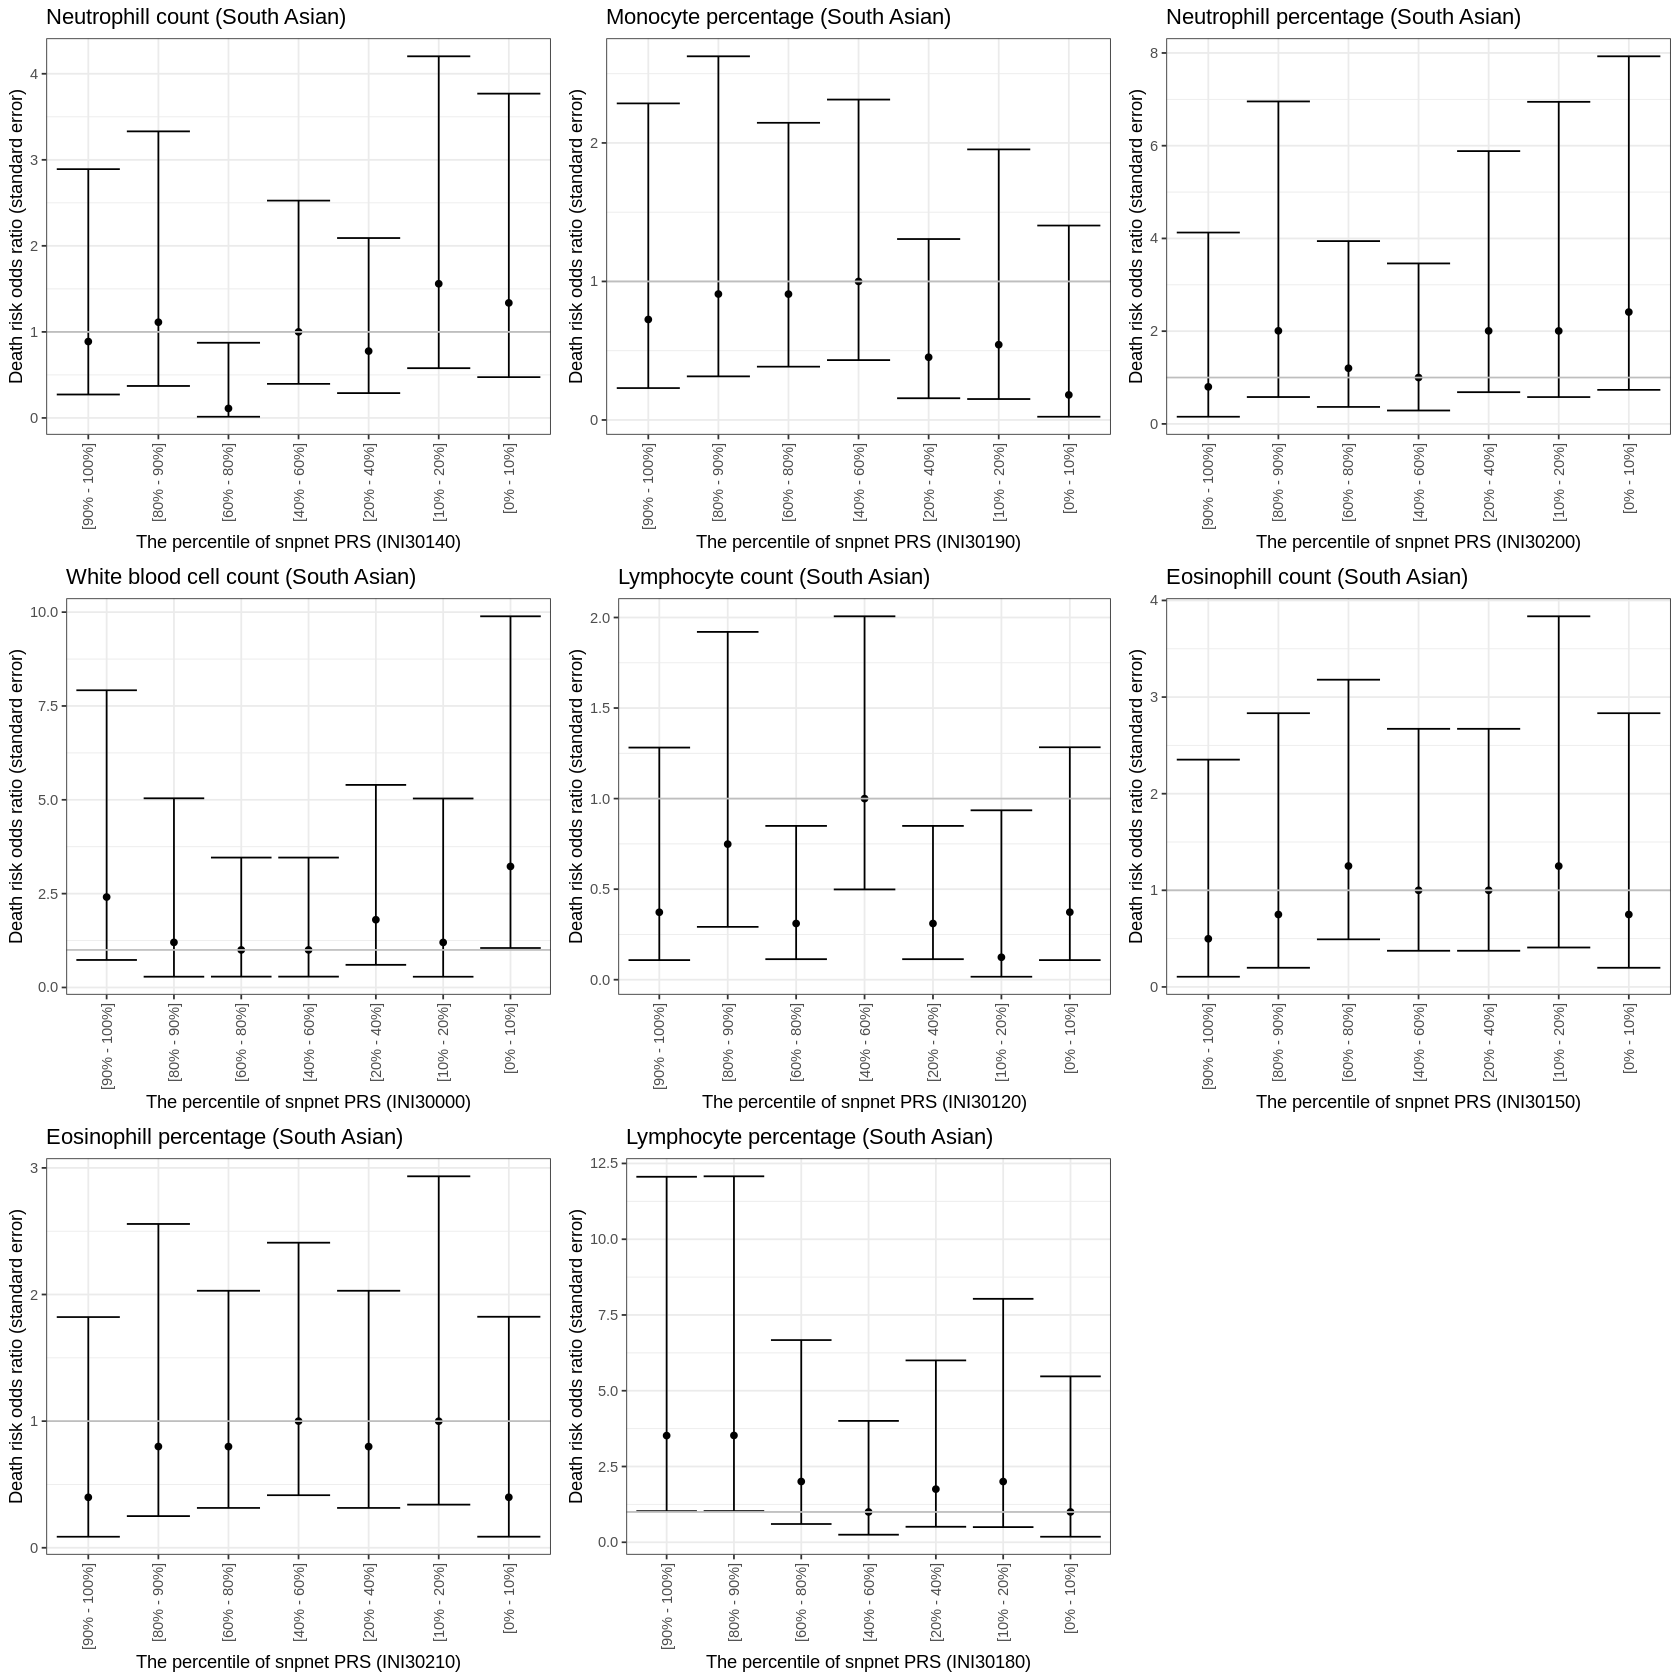

In [318]:
# we sort the plots by P-value
plist <- phewas_summary_df %>%
filter(population == pop, phenotype == phe) %>%
arrange(P) %>% select(PRS) %>% pull() %>%
lapply(function(PRS_col){OR_plots[[ pop ]][[ phe ]][[ PRS_col ]] })

# plist <- OR_plots[[ pop ]][[ phe ]]

n <- length(plist)
nCol <- 3
options(repr.plot.width=14, repr.plot.height=14)
do.call("grid.arrange", c(plist, ncol=nCol))


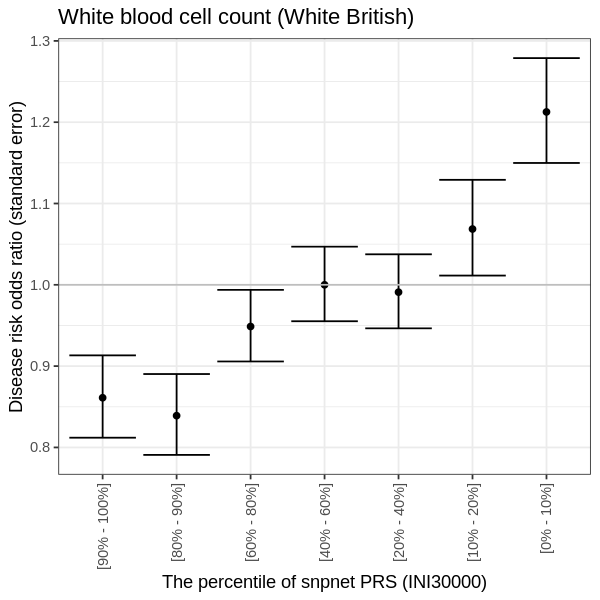

In [319]:
pop <- 'white_british' 
PRS_col <- 'INI30000_PRS'
phe <- 'ICD_disease'
options(repr.plot.width=5, repr.plot.height=5)
OR_plots[[ pop ]][[ phe ]][[PRS_col]]